In [1]:
import warnings
warnings.filterwarnings("ignore")

# Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt

# Содержание
1. Скачивание и обработка данных
    - Для простоты уменьшаем количество данных, переходим от часовых показателей к ежедневным
    - Преобразуем данные так, чтобы индексом была дата (а не просто число), а для каждого момента времени по столбцам были указаны рассматриваемые криптовалюты
    - Некоторые криптовалюты имеют слишком мало данных, удаляем их из рассмотрения, список сокращается до 29 криптовалют
    - Удаляем строки с данными, в которых есть пропуски (те даты, в которые не торговалась хотя бы одна из валют)
    - Будем рассматривать только криптовалюты с наибольшей доходностью, список сокращен до 5 криптовалют
    - Итогом данных операций является таблица D


2. Постороение фичей
    - Используем SMA (ex. f_open7), агрегированные индексы (срелний и средневзвешанный)
    - Строим матрицу корреляций


3. Построение модели для предсказания цены каждой из выбранных криптовалют
    - Используется RandomForestRegressor
    - Предсказываем доходность на основе 8 индивидуальных фичей, а также 2х агрегированных индексов
    - Используется Shift, чтобы не предсказывать цены на основе фичей на основе предсказываемых доходностей
    - Считаем скоры (0 - плохое предсказание, <0 - ужасное предсказание). Заметим, что у полученных все скоры на test положительны, что дает надежду о качестве построенных моделей
    - Создаем столбец с предсказанием для каждой криптовалюты
    - Получаем итоговую таблицу E, в которой можно сравнить факт с предсказанием
    - Получаем итоговую таблицу predicted_prices, в которой содержатся предсказанные цены. На основе этих предсказаний будем делать портфель.



4. Modern Portfolio Theory.
    - Портфель обновляется раз в месяц
    - Подбираем веса портфеля так, чтобы месячный коэфффициент Шарпа был максимален
    - Perfomance - показатели перфоманса полученнго портфеля (коэффициент Шарпа, веса, доходность, волатильность)
    

## Скачиваем и обрабатываем данные

In [3]:
df = pd.read_csv('./market_data_train.csv')
df

,symbol,time,open,high,low,close,market_cap,n_trades,volume,taker_buy_volume
0,1INCH,2020-12-25 06:00:00,0.2000,3.0885,0.2000,2.5826,6.707592e+07,48768,3.553052e+07,1.724763e+07
1,1INCH,2020-12-25 07:00:00,2.5824,2.6900,2.2249,2.5059,6.508385e+07,31099,2.244087e+07,9.861481e+06
2,1INCH,2020-12-25 08:00:00,2.5152,2.8870,2.3609,2.6237,6.814338e+07,33001,2.130043e+07,1.160785e+07
3,1INCH,2020-12-25 09:00:00,2.6318,2.8247,2.4650,2.6134,6.787587e+07,30459,1.749181e+07,9.087566e+06
4,1INCH,2020-12-25 10:00:00,2.6104,2.7498,2.5629,2.6365,6.847583e+07,21023,9.919400e+06,4.798067e+06
...,...,...,...,...,...,...,...,...,...,...
2235079,ZRX,2021-05-31 16:00:00,0.9755,1.0160,0.9731,1.0149,8.544659e+08,1745,5.283764e+05,2.847624e+05
2235080,ZRX,2021-05-31 17:00:00,1.0147,1.0200,0.9871,1.0047,8.458783e+08,1451,3.980687e+05,1.617346e+05
2235081,ZRX,2021-05-31 18:00:00,1.0064,1.0077,0.9830,0.9884,8.321549e+08,894,2.268356e+05,7.276305e+04
2235082,ZRX,2021-05-31 19:00:00,0.9889,0.9905,0.9827,0.9865,8.305553e+08,346,7.615435e+04,3.804757e+04


Создадим новый столбец, который будет включать в себя только дату (без времени суток)

In [4]:
import datetime
df['only_date'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S').date() for d in df['time']]

In [5]:
df

,symbol,time,open,high,low,close,market_cap,n_trades,volume,taker_buy_volume,only_date
0,1INCH,2020-12-25 06:00:00,0.2000,3.0885,0.2000,2.5826,6.707592e+07,48768,3.553052e+07,1.724763e+07,2020-12-25
1,1INCH,2020-12-25 07:00:00,2.5824,2.6900,2.2249,2.5059,6.508385e+07,31099,2.244087e+07,9.861481e+06,2020-12-25
2,1INCH,2020-12-25 08:00:00,2.5152,2.8870,2.3609,2.6237,6.814338e+07,33001,2.130043e+07,1.160785e+07,2020-12-25
3,1INCH,2020-12-25 09:00:00,2.6318,2.8247,2.4650,2.6134,6.787587e+07,30459,1.749181e+07,9.087566e+06,2020-12-25
4,1INCH,2020-12-25 10:00:00,2.6104,2.7498,2.5629,2.6365,6.847583e+07,21023,9.919400e+06,4.798067e+06,2020-12-25
...,...,...,...,...,...,...,...,...,...,...,...
2235079,ZRX,2021-05-31 16:00:00,0.9755,1.0160,0.9731,1.0149,8.544659e+08,1745,5.283764e+05,2.847624e+05,2021-05-31
2235080,ZRX,2021-05-31 17:00:00,1.0147,1.0200,0.9871,1.0047,8.458783e+08,1451,3.980687e+05,1.617346e+05,2021-05-31
2235081,ZRX,2021-05-31 18:00:00,1.0064,1.0077,0.9830,0.9884,8.321549e+08,894,2.268356e+05,7.276305e+04,2021-05-31
2235082,ZRX,2021-05-31 19:00:00,0.9889,0.9905,0.9827,0.9865,8.305553e+08,346,7.615435e+04,3.804757e+04,2021-05-31


Создадим новую таблицу A, которая будет иметь агрегированные данные за день, используя groupby для каждой бумаги и даты

In [6]:
A = pd.DataFrame()
temp_open = df.copy()
temp_open = temp_open.groupby(['symbol', 'only_date']).first()['open']
temp_high = df.copy()
temp_high = temp_high.groupby(['symbol', 'only_date']).max()['high']
temp_low = df.copy()
temp_low = temp_low.groupby(['symbol', 'only_date']).min()['low']
temp_close = df.copy()
temp_close = temp_close.groupby(['symbol', 'only_date']).last()['close']
temp_mc = df.copy()
temp_mc = temp_mc.groupby(['symbol', 'only_date']).sum()['market_cap']
temp_tr = df.copy()
temp_tr = temp_tr.groupby(['symbol', 'only_date']).sum()['n_trades']
temp_vol = df.copy()
temp_vol = temp_vol.groupby(['symbol', 'only_date']).sum()['volume']
temp_tbv = df.copy()
temp_tbv = temp_tbv.groupby(['symbol', 'only_date']).sum()['taker_buy_volume']
A['open'] = temp_open
A['high'] = temp_high
A['low'] = temp_low
A['close'] = temp_close
A['market_cap'] = temp_mc
A['n_trades'] = temp_tr
A['volume'] = temp_vol
A['taker_buy_volume'] = temp_tbv
A

open    high     low   close    market_cap  n_trades  \
symbol only_date                                                            
1INCH  2020-12-25  0.2000  3.0885  0.2000  2.1936  1.100153e+09    596566   
       2020-12-26  2.1936  2.4609  1.5717  1.6221  1.141930e+09    314848   
       2020-12-27  1.6206  1.6668  1.0360  1.1001  8.263693e+08    301197   
       2020-12-28  1.1019  1.2787  1.0353  1.0906  1.572571e+09    157507   
       2020-12-29  1.0889  1.1344  0.7541  0.8852  1.556105e+09    164635   
...                   ...     ...     ...     ...           ...       ...   
ZRX    2021-05-27  1.1324  1.1888  1.0225  1.1076  2.262910e+10     36198   
       2021-05-28  1.1078  1.1243  0.9245  0.9421  2.045077e+10     43691   
       2021-05-29  0.9420  1.0089  0.8432  0.8922  1.887528e+10     27272   
       2021-05-30  0.8905  0.9909  0.8421  0.9444  1.893287e+10     22351   
       2021-05-31  0.9431  1.0200  0.8874  0.9988  1.686183e+10     16946   

                         volume  taker_buy_volume  
symbol only_date                                   
1INCH  2020-12-25  2.923449e+08      1.444582e+08  
       2020-12-26  1.132451e+08      5.393879e+07  
       2020-12-27  9.892812e+07      4.747393e+07  
       2020-12-28  4.796362e+07      2.439249e+07  
       2020-12-29  4.745768e+07      2.154755e+07  
...                         ...               ...  
ZRX    2021-05-27  1.049805e+07      5.423639e+06  
       2021-05-28  1.264365e+07      6.685530e+06  
       2021-05-29  6.976375e+06      3.629081e+06  
       2021-05-30  5.166297e+06      2.636999e+06  
       2021-05-31  4.634872e+06      2.241551e+06  

[93597 rows x 8 columns]

In [104]:
B = A.copy() #чтобы не проигрывать код в предыдущей строке много раз

In [105]:
B = pd.DataFrame(B)
B['symbol'] = [i[0] for i in list(B.index[:])]
B['date'] = [i[1] for i in list(B.index[:])]
B.index = [i for i in range(93597)]

In [106]:
B['close_pct'] = B['close'].pct_change()
# создаем вспомогательный столбец pnl_without_cumsum
B['pnl_without_cumsum'] = 0
B['pnl_without_cumsum'] = B['close'] - B['close'].shift(1)
B['pnl'] = B['pnl_without_cumsum'].cumsum()
B = B.drop('pnl_without_cumsum', axis = 1)

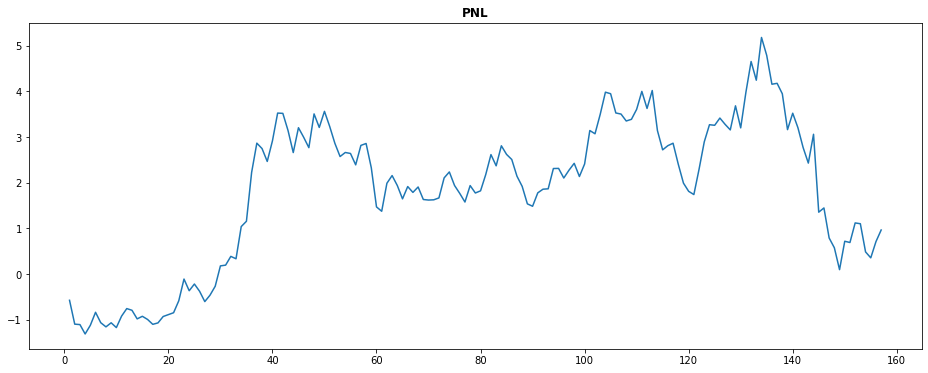

In [107]:
B['pnl'][B.symbol == '1INCH'].plot(figsize=(16, 6))
plt.title("PNL", weight="bold")

plt.show()

In [108]:
# Хотим посмотреть 12 фичей: для 4х типов цен и 3х видов параметров (всего 12)
price_type = ['open', 'high', 'low', 'close']
sma_days = [7, 30]
f_names = []
for p in price_type:
    for h in sma_days:
        name = 'f_' + p + str(h)
        data = B[p]
        rolling_mean = data.rolling(window = h).mean()
        B[name] = B[p]/rolling_mean - 1
        f_names.append(name)

In [109]:
C = B.copy()

In [110]:
# отсортируем по времени
C.sort_values(by = 'date', inplace = True)
date = C.date
C.drop(['date'], axis = 1, inplace = True)
C.index = date
C

,open,high,low,close,market_cap,n_trades,volume,taker_buy_volume,symbol,close_pct,pnl,f_open7,f_open30,f_high7,f_high30,f_low7,f_low30,f_close7,f_close30
date,,,,,,,,,,,,,,,,,,,
2018-01-01,13740.9600,13818.550,12750.0000,13452.0000,5.384947e+12,101686,1.102353e+08,5.080436e+07,BTC,2915.043442,13449.8064,5.986020,28.612534,5.985176,28.592692,5.986036,28.620025,5.985755,28.609428
2018-01-01,8.5299,8.700,7.8000,8.3706,1.963553e+10,19480,5.154648e+06,2.251361e+06,BNB,39.089080,6.1770,5.109200,13.599027,4.998924,13.008248,5.113804,13.922737,5.078527,13.620727
2018-01-01,223.5000,231.190,212.7400,223.9400,2.911334e+11,16653,4.368980e+06,2.090275e+06,LTC,63.987376,221.7464,5.343469,16.168830,5.334278,15.544131,5.386353,16.717614,5.368453,16.277752
2018-01-01,733.9900,763.550,716.8000,754.5800,1.726566e+12,72335,3.847616e+07,1.998742e+07,ETH,10.118347,752.3864,3.420702,5.945890,3.402184,5.470962,3.529939,6.580068,3.506308,6.040821
2018-01-01,74.8530,80.000,71.0500,79.0390,1.168199e+11,10271,5.719370e+06,3.611816e+06,NEO,23.256253,76.8454,4.597795,9.954354,4.590809,9.886171,4.648354,10.346777,4.664498,10.444047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,0.6340,0.666,0.5850,0.6490,5.257224e+08,13293,2.505076e+06,1.266228e+06,DREP,0.025276,-1.5446,0.088813,-0.387045,-0.003420,-0.403618,0.099034,-0.367385,0.081667,-0.350394
2021-05-31,12.9040,13.997,12.1370,13.5700,1.669679e+10,6881,1.560066e+06,7.863127e+05,UMA,0.053817,11.3764,-0.062053,-0.392743,-0.049827,-0.381344,-0.043911,-0.362967,-0.009045,-0.347549
2021-05-31,9.2870,11.225,8.6760,10.9040,8.059109e+08,33587,6.464907e+06,3.381566e+06,UNFI,0.168828,8.7104,-0.103609,-0.476850,-0.047703,-0.415602,-0.056136,-0.447214,0.045675,-0.368222


In [113]:
pearsoncorr = C.corr(method='pearson')
pearsoncorr

,open,high,low,close,market_cap,n_trades,volume,taker_buy_volume,close_pct,pnl,f_open7,f_open30,f_high7,f_high30,f_low7,f_low30,f_close7,f_close30
open,1.000000,0.998225,0.997103,0.997241,0.735572,0.346755,0.460400,0.456430,0.000038,0.997241,0.007906,0.015480,0.006798,0.015038,0.006386,0.014671,0.005910,0.014689
high,0.998225,1.000000,0.995985,0.998640,0.722050,0.342785,0.454526,0.450868,0.001112,0.998640,0.008973,0.017230,0.009003,0.017352,0.008062,0.016674,0.008276,0.017038
low,0.997103,0.995985,1.000000,0.998140,0.749875,0.348958,0.462011,0.458418,0.000031,0.998140,0.007868,0.014710,0.007433,0.014579,0.007903,0.014616,0.007242,0.014520
close,0.997241,0.998640,0.998140,1.000000,0.735126,0.346134,0.458518,0.455038,0.000133,1.000000,0.008008,0.015662,0.008247,0.015833,0.007814,0.015431,0.008194,0.015803
market_cap,0.735572,0.722050,0.749875,0.735126,1.000000,0.531295,0.692404,0.688212,0.000634,0.735126,0.006008,0.011781,0.005787,0.011557,0.005418,0.011405,0.005356,0.011456
n_trades,0.346755,0.342785,0.348958,0.346134,0.531295,1.000000,0.921693,0.924397,0.004331,0.346146,0.078584,0.095552,0.107150,0.117425,0.061977,0.085492,0.087583,0.104687
volume,0.460400,0.454526,0.462011,0.458518,0.692404,0.921693,1.000000,0.999604,0.002102,0.458521,0.046175,0.057265,0.061505,0.070218,0.034785,0.050289,0.050204,0.062515
taker_buy_volume,0.456430,0.450868,0.458418,0.455038,0.688212,0.924397,0.999604,1.000000,0.002016,0.455041,0.046868,0.057937,0.063372,0.071596,0.036130,0.051221,0.052306,0.063919
close_pct,0.000038,0.001112,0.000031,0.000133,0.000634,0.004331,0.002102,0.002016,1.000000,0.000133,0.132536,0.182841,0.130043,0.182556,0.133343,0.183968,0.134674,0.184990
pnl,0.997241,0.998640,0.998140,1.000000,0.735126,0.346146,0.458521,0.455041,0.000133,1.000000,0.008008,0.015662,0.008247,0.015833,0.007814,0.015431,0.008194,0.015803


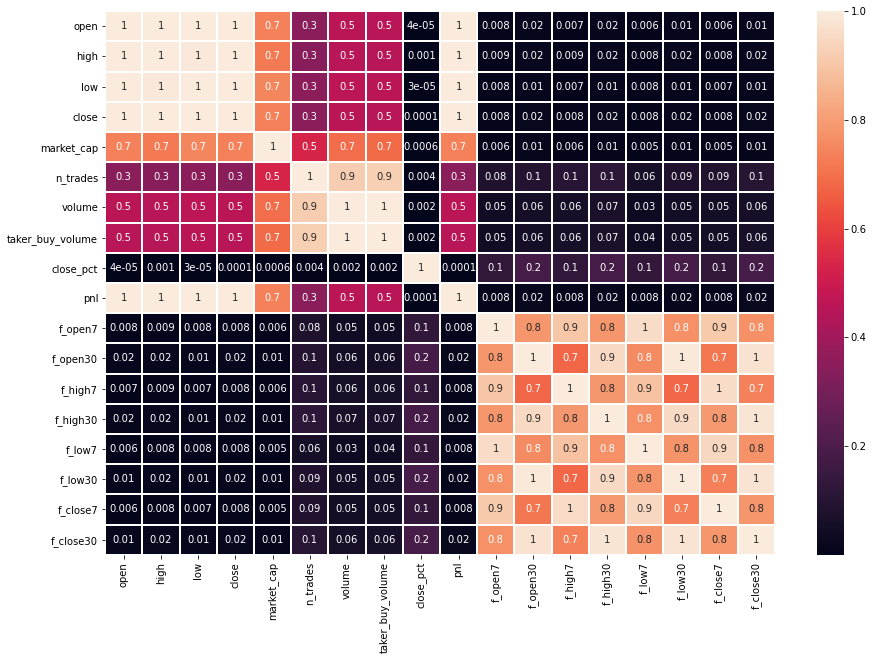

In [114]:
plt.rcParams['figure.figsize'] = (15.0, 10.0)
sb.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
#             cmap='RdBu_r',
            annot=True,
            linewidth=1,
            fmt='.1g')

__________

In [96]:
all_dates = C.index.unique()
all_symbols = C.symbol.unique()
D = pd.DataFrame(index = all_dates)
for i in all_symbols:
    D[i] = C['close'].loc[C['symbol'] == i]

Удалим криптовалюты, по которым мало измерений (<800)

In [97]:
for name in all_symbols:
    if D[name].count() < 800:
        D.drop([name], axis = 1, inplace = True)
D.count()

BTC      1247
BNB      1247
LTC      1247
ETH      1247
NEO      1247
QTUM     1170
ADA      1141
XRP      1124
EOS      1100
IOTA     1097
XLM      1097
ONT      1089
TRX      1086
ETC      1085
ICX      1084
NULS     1044
VET      1042
LINK      867
WAVES     865
BTT       852
ONG       836
HOT       834
ZIL       833
FET       824
ZRX       824
BAT       820
XMR       809
ZEC       803
IOST      802
dtype: int64

In [98]:
D = D.dropna(axis = 0)
D

,BTC,BNB,LTC,ETH,NEO,QTUM,ADA,XRP,EOS,IOTA,...,BTT,ONG,HOT,ZIL,FET,ZRX,BAT,XMR,ZEC,IOST
date,,,,,,,,,,,,,,,,,,,,,
2019-03-22,3990.94,15.1952,59.29,136.11,9.140,2.510,0.05801,0.31021,3.6203,0.3106,...,0.000779,0.6394,0.001194,0.01934,0.20600,0.2703,0.1986,52.93,55.20,0.008569
2019-03-23,3995.35,15.0339,60.67,136.97,9.302,2.661,0.06329,0.31086,3.6567,0.3117,...,0.000802,0.6306,0.001167,0.01957,0.20290,0.2690,0.1998,52.51,56.44,0.008738
2019-03-24,3986.57,17.1997,59.67,135.91,9.075,2.579,0.06043,0.30739,3.6323,0.3064,...,0.000783,0.6231,0.001155,0.01997,0.20550,0.2864,0.2090,52.56,57.07,0.008396
2019-03-25,3936.00,16.6061,59.03,133.98,8.897,2.483,0.05825,0.30300,3.6487,0.2977,...,0.000748,0.5924,0.001112,0.01885,0.19590,0.2769,0.2039,51.15,55.05,0.008129
2019-03-26,3935.08,16.2555,58.27,133.86,8.810,2.462,0.06158,0.29937,3.6544,0.2926,...,0.000746,0.5783,0.001087,0.01842,0.18180,0.2871,0.2147,51.77,54.00,0.008196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,38503.15,367.7300,193.76,2755.60,62.893,14.558,1.65380,0.97500,7.0946,1.1749,...,0.004163,1.0722,0.009546,0.12149,0.29647,1.1076,0.8652,252.13,148.79,0.034478
2021-05-28,35061.65,325.2600,173.64,2388.80,53.362,11.943,1.48530,0.88020,5.9919,1.0178,...,0.003690,1.1233,0.008129,0.10859,0.28747,0.9421,0.7288,254.32,155.02,0.029057
2021-05-29,34467.84,303.9200,163.18,2272.04,50.103,11.159,1.38890,0.82330,5.9614,0.9772,...,0.003519,1.0188,0.008180,0.09832,0.28181,0.8922,0.6762,241.59,146.70,0.029153


In [99]:
returns_daily = D.pct_change()
for name in returns_daily.columns:
    if returns_daily[name].mean() < 0.005:
        returns_daily.drop([name], axis = 1, inplace = True)
        D.drop([name], axis = 1, inplace = True)
print(returns_daily.shape)
returns_daily.mean()

(802, 5)


BNB     0.005679
ADA     0.005868
ETC     0.005362
VET     0.006075
LINK    0.007747
dtype: float64

In [100]:
D

,BNB,ADA,ETC,VET,LINK
date,,,,,
2019-03-22,15.1952,0.05801,4.8777,0.005771,0.4621
2019-03-23,15.0339,0.06329,4.8579,0.005832,0.4590
2019-03-24,17.1997,0.06043,4.7949,0.005722,0.4542
2019-03-25,16.6061,0.05825,4.6630,0.005601,0.4697
2019-03-26,16.2555,0.06158,4.6094,0.005488,0.4571
...,...,...,...,...,...
2021-05-27,367.7300,1.65380,74.4850,0.123090,31.7350
2021-05-28,325.2600,1.48530,67.3180,0.106040,27.4980
2021-05-29,303.9200,1.38890,63.6230,0.098340,25.1190


# Построение фичей

In [194]:
all_dates = D.index.unique()
all_symbols = D.columns.unique()
X = pd.DataFrame(index = all_dates)
features_names = []
target_names = []
for i in all_symbols:
    X[i + '_close'] = C['close'].loc[C['symbol'] == i]
    X[i + '_MC'] = C['market_cap'].loc[C['symbol'] == i]
    X[i + '_pnl'] = C['pnl'].loc[C['symbol'] == i]
    X[i + '_r'] = C['close_pct'].loc[C['symbol'] == i]
    target_names.append(i + '_r')
    for j in f_names:
        X[i + j] = C[j].loc[C['symbol'] == i]
        features_names.append(i+j)

In [195]:
# агрегированные индексы
X['aggregate_i_w'] = 0
X['aggregate_i'] = 0
X['MC_total'] = 0
X['Defined'] = X.count(axis = 1)
X = X.fillna(0)
for i in all_symbols:
    X['aggregate_i_w'] = X['aggregate_i_w'] + X[i + '_r'] * X[i + '_MC']
    X['aggregate_i'] = X['aggregate_i'] + X[i + '_r']
    X['MC_total'] = X['MC_total'] + X[i + '_MC']
X['aggregate_i_w'] = X['aggregate_i_w'] / X['MC_total']
X['aggregate_i'] = X['aggregate_i'] / X['Defined']
X = X.drop(['MC_total', 'Defined'], axis = 1)
features_names.append('aggregate_i_w')
features_names.append('aggregate_i')
print(features_names)

['BNBf_open7', 'BNBf_open30', 'BNBf_high7', 'BNBf_high30', 'BNBf_low7', 'BNBf_low30', 'BNBf_close7', 'BNBf_close30', 'ADAf_open7', 'ADAf_open30', 'ADAf_high7', 'ADAf_high30', 'ADAf_low7', 'ADAf_low30', 'ADAf_close7', 'ADAf_close30', 'ETCf_open7', 'ETCf_open30', 'ETCf_high7', 'ETCf_high30', 'ETCf_low7', 'ETCf_low30', 'ETCf_close7', 'ETCf_close30', 'VETf_open7', 'VETf_open30', 'VETf_high7', 'VETf_high30', 'VETf_low7', 'VETf_low30', 'VETf_close7', 'VETf_close30', 'LINKf_open7', 'LINKf_open30', 'LINKf_high7', 'LINKf_high30', 'LINKf_low7', 'LINKf_low30', 'LINKf_close7', 'LINKf_close30', 'aggregate_i_w', 'aggregate_i']


In [196]:
X

,BNB_close,BNB_MC,BNB_pnl,BNB_r,BNBf_open7,BNBf_open30,BNBf_high7,BNBf_high30,BNBf_low7,BNBf_low30,...,LINKf_open7,LINKf_open30,LINKf_high7,LINKf_high30,LINKf_low7,LINKf_low30,LINKf_close7,LINKf_close30,aggregate_i_w,aggregate_i
date,,,,,,,,,,,,,,,,,,,,,
2019-03-22,15.1952,5.017329e+10,13.0016,0.052875,-0.056258,0.108701,-0.027532,0.126911,-0.038796,0.132750,...,-0.029821,0.017668,-0.037399,-0.017435,-0.029767,0.017250,-0.025105,0.016274,0.058011,0.003037
2019-03-23,15.0339,5.133370e+10,12.8403,-0.010615,-0.008223,0.154527,-0.009040,0.130210,0.008907,0.174720,...,-0.024945,0.015339,-0.030265,-0.018617,-0.009311,0.033025,-0.025625,0.008127,0.025453,0.001273
2019-03-24,17.1997,5.450866e+10,15.0061,0.144061,-0.010317,0.128934,0.107936,0.260885,-0.002959,0.139377,...,-0.024797,0.007846,-0.027772,-0.023698,-0.015738,0.018655,-0.028598,-0.002883,0.049499,0.000898
2019-03-25,16.6061,5.662045e+10,14.4125,-0.034512,0.116100,0.271004,0.083140,0.230855,0.085526,0.233085,...,-0.027421,-0.002509,0.037619,0.043330,-0.024244,0.001825,0.006428,0.030292,-0.031169,-0.001351
2019-03-26,16.2555,5.507873e+10,14.0619,-0.021113,0.066800,0.209467,0.041756,0.178796,0.041782,0.171080,...,0.009001,0.032207,0.014584,0.020981,-0.003464,0.013850,-0.015083,-0.000852,0.005052,-0.000356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,367.7300,1.353735e+12,365.5364,-0.015396,0.120778,-0.301173,0.056046,-0.311018,0.185412,-0.307762,...,0.241822,-0.158529,0.210205,-0.150584,0.318435,-0.141871,0.199617,-0.179768,-0.031043,-0.002965
2021-05-28,325.2600,1.251586e+12,323.0664,-0.115492,0.117871,-0.302871,0.035162,-0.327516,0.068454,-0.354268,...,0.199663,-0.179824,0.101374,-0.222524,0.143008,-0.227704,0.026067,-0.284165,-0.112101,-0.009296
2021-05-29,303.9200,1.190503e+12,301.7264,-0.065609,-0.015442,-0.374385,-0.042981,-0.365315,0.004779,-0.378499,...,0.026207,-0.284142,-0.000115,-0.277490,0.016178,-0.298148,-0.069829,-0.339690,-0.067031,-0.005469


## ML модели для предсказания цен криптовалют

In [197]:
targets = X[target_names]
features = X[features_names]

In [198]:
# targets

In [199]:
# features

In [200]:
# # разделили dataset на 2 части: тренировачный (85%) и тестовый
# import statsmodels.api as sm
# train_size = int(0.85 * targets.shape[0])
# train_features = features[:train_size]
# train_targets = targets[:train_size]
# test_features = features[train_size:]
# test_targets = targets[train_size:]

In [213]:
# разделили dataset на 2 части: тренировачный (85%) и тестовый
import statsmodels.api as sm
train_size = int(0.85 * targets.shape[0])
train_features = features[:train_size].shift(1).dropna() #смещение на 1, так как иначе используем фичи, которые построены на основе цен, которые пытаемся предсказать
train_targets = targets[:train_size-1]
test_features = features[train_size:].shift(1).dropna()
test_targets = targets[train_size:-1]

In [214]:
train_features

,BNBf_open7,BNBf_open30,BNBf_high7,BNBf_high30,BNBf_low7,BNBf_low30,BNBf_close7,BNBf_close30,ADAf_open7,ADAf_open30,...,LINKf_open7,LINKf_open30,LINKf_high7,LINKf_high30,LINKf_low7,LINKf_low30,LINKf_close7,LINKf_close30,aggregate_i_w,aggregate_i
date,,,,,,,,,,,,,,,,,,,,,
2019-03-23,-0.056258,0.108701,-0.027532,0.126911,-0.038796,0.132750,-0.008185,0.154409,0.036379,0.155127,...,-0.029821,0.017668,-0.037399,-0.017435,-0.029767,0.017250,-0.025105,0.016274,0.058011,0.003037
2019-03-24,-0.008223,0.154527,-0.009040,0.130210,0.008907,0.174720,-0.010275,0.128892,0.107423,0.252681,...,-0.024945,0.015339,-0.030265,-0.018617,-0.009311,0.033025,-0.025625,0.008127,0.025453,0.001273
2019-03-25,-0.010317,0.128934,0.107936,0.260885,-0.002959,0.139377,0.116197,0.271016,0.169715,0.349088,...,-0.024797,0.007846,-0.027772,-0.023698,-0.015738,0.018655,-0.028598,-0.002883,0.049499,0.000898
2019-03-26,0.116100,0.271004,0.083140,0.230855,0.085526,0.233085,0.067032,0.209649,0.086009,0.274123,...,-0.027421,-0.002509,0.037619,0.043330,-0.024244,0.001825,0.006428,0.030292,-0.031169,-0.001351
2019-03-27,0.066800,0.209467,0.041756,0.178796,0.041782,0.171080,0.035603,0.166393,0.024656,0.220086,...,0.009001,0.032207,0.014584,0.020981,-0.003464,0.013850,-0.015083,-0.000852,0.005052,-0.000356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-26,0.002498,0.037248,0.005205,0.033154,0.023712,0.052221,0.004104,0.018865,-0.007417,0.264284,...,0.119236,0.486344,0.092420,0.427537,0.117776,0.465839,0.059255,0.390188,-0.023412,-0.001689
2021-01-27,0.004233,0.018912,0.001383,0.007421,0.009778,0.023455,0.014251,0.017990,-0.013407,0.217485,...,0.059005,0.389623,0.009047,0.301743,0.061247,0.371100,0.027457,0.336899,-0.003792,-0.000456
2021-01-28,0.014393,0.018078,-0.005928,-0.009041,0.009773,0.015756,0.007455,0.003043,0.004802,0.196833,...,0.026954,0.335879,-0.029409,0.241837,-0.014436,0.262001,-0.070602,0.185886,-0.073988,-0.005719


In [215]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor(max_depth=6)

In [216]:
for i in range(len(D.columns)): #для каждой из пяти выбранных криптовалют
    # D.columns[i] - название i криптовалюты
    a = 8 * i # у нас 8 индивидуальных фичей для каждой криптовалюты (4 вида цен, 2 вида промежутков времени - неделя/месяц)
    b = 8 * (i + 1)
    features_names_for_i = features_names[a:b] + features_names[-2:] # названия фичей для выбранной криптовалюты
    train_features_for_i = train_features[features_names_for_i]
    train_targets_for_i = train_targets[target_names[i]]
    test_features_for_i = test_features[features_names_for_i]
    test_targets_for_i = test_targets[target_names[i]]
    # фитим модель
    decision_tree.fit(train_features_for_i, train_targets_for_i)
    print(target_names[i], "score_for_train_set:", decision_tree.score(train_features_for_i, train_targets_for_i))
    print(target_names[i], "score_for_test_set:", decision_tree.score(test_features_for_i, test_targets_for_i))
    print()
    # строим новый столбик в таблице X с предсказаниями цен
    X[D.columns[i] + ' %_pred'] = decision_tree.predict(X[features_names_for_i]) # предсказание процентного изменения
    X[D.columns[i] + ' price_date-1'] = X[D.columns[i] + '_close'].shift(1)
    # предсказание цены актива на основе доходности и предыдущей цены
    X[D.columns[i] + ' p_pred'] = X[D.columns[i] + ' price_date-1']*(1+X[D.columns[i] + ' %_pred'])

BNB_r score_for_train_set: 0.9095276315263648
BNB_r score_for_test_set: 0.5753742847151472

ADA_r score_for_train_set: 0.9060615723034219
ADA_r score_for_test_set: 0.3247484450141135

ETC_r score_for_train_set: 0.8985619219600715
ETC_r score_for_test_set: 0.6701769431668095

VET_r score_for_train_set: 0.8839719338035011
VET_r score_for_test_set: 0.5581744942506435

LINK_r score_for_train_set: 0.8858370756948697
LINK_r score_for_test_set: 0.5899220168059712



In [217]:
X

,BNB_close,BNB_MC,BNB_pnl,BNB_r,BNBf_open7,BNBf_open30,BNBf_high7,BNBf_high30,BNBf_low7,BNBf_low30,...,ADA p_pred,ETC %_pred,ETC price_date-1,ETC p_pred,VET %_pred,VET price_date-1,VET p_pred,LINK %_pred,LINK price_date-1,LINK p_pred
date,,,,,,,,,,,,,,,,,,,,,
2019-03-22,15.1952,5.017329e+10,13.0016,0.052875,-0.056258,0.108701,-0.027532,0.126911,-0.038796,0.132750,...,NaN,0.017789,NaN,NaN,0.009919,NaN,NaN,0.053482,NaN,NaN
2019-03-23,15.0339,5.133370e+10,12.8403,-0.010615,-0.008223,0.154527,-0.009040,0.130210,0.008907,0.174720,...,0.063014,0.007203,4.8777,4.912833,0.009919,0.005771,0.005828,-0.001179,0.4621,0.461555
2019-03-24,17.1997,5.450866e+10,15.0061,0.144061,-0.010317,0.128934,0.107936,0.260885,-0.002959,0.139377,...,0.062469,0.004128,4.8579,4.877954,0.009919,0.005832,0.005890,-0.001179,0.4590,0.458459
2019-03-25,16.6061,5.662045e+10,14.4125,-0.034512,0.116100,0.271004,0.083140,0.230855,0.085526,0.233085,...,0.057957,-0.033795,4.7949,4.632857,-0.033427,0.005722,0.005531,0.020474,0.4542,0.463499
2019-03-26,16.2555,5.507873e+10,14.0619,-0.021113,0.066800,0.209467,0.041756,0.178796,0.041782,0.171080,...,0.058541,-0.005771,4.6630,4.636090,-0.011548,0.005601,0.005536,-0.011510,0.4697,0.464294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,367.7300,1.353735e+12,365.5364,-0.015396,0.120778,-0.301173,0.056046,-0.311018,0.185412,-0.307762,...,1.688250,-0.025001,78.3850,76.425259,-0.050271,0.129730,0.123208,-0.045141,32.6680,31.193331
2021-05-28,325.2600,1.251586e+12,323.0664,-0.115492,0.117871,-0.302871,0.035162,-0.327516,0.068454,-0.354268,...,1.452119,-0.122938,74.4850,65.327936,-0.143429,0.123090,0.105435,-0.023388,31.7350,30.992789
2021-05-29,303.9200,1.190503e+12,301.7264,-0.065609,-0.015442,-0.374385,-0.042981,-0.365315,0.004779,-0.378499,...,1.352094,-0.057058,67.3180,63.476990,-0.075181,0.106040,0.098068,-0.094357,27.4980,24.903365


Построим таблицу (E), в которой можно сравнить предсказания с реальными ценами в этот день

In [219]:
E = X.copy()
E = E.drop(features_names, axis = 1)
for i in D.columns:
    E = E.drop([i + '_MC'], axis = 1)
    E = E.drop([i + '_pnl'], axis = 1)
    E = E.drop([i + '_r'], axis = 1)
    E = E.drop([i + ' %_pred'], axis = 1)
    E = E.drop([i + ' price_date-1'], axis = 1)
E

,BNB_close,ADA_close,ETC_close,VET_close,LINK_close,BNB p_pred,ADA p_pred,ETC p_pred,VET p_pred,LINK p_pred
date,,,,,,,,,,
2019-03-22,15.1952,0.05801,4.8777,0.005771,0.4621,NaN,NaN,NaN,NaN,NaN
2019-03-23,15.0339,0.06329,4.8579,0.005832,0.4590,15.251171,0.063014,4.912833,0.005828,0.461555
2019-03-24,17.1997,0.06043,4.7949,0.005722,0.4542,17.199700,0.062469,4.877954,0.005890,0.458459
2019-03-25,16.6061,0.05825,4.6630,0.005601,0.4697,16.627298,0.057957,4.632857,0.005531,0.463499
2019-03-26,16.2555,0.06158,4.6094,0.005488,0.4571,16.321232,0.058541,4.636090,0.005536,0.464294
...,...,...,...,...,...,...,...,...,...,...
2021-05-27,367.7300,1.65380,74.4850,0.123090,31.7350,355.026590,1.688250,76.425259,0.123208,31.193331
2021-05-28,325.2600,1.48530,67.3180,0.106040,27.4980,346.878099,1.452119,65.327936,0.105435,30.992789
2021-05-29,303.9200,1.38890,63.6230,0.098340,25.1190,305.868569,1.352094,63.476990,0.098068,24.903365


In [223]:
predicted_prices = E.copy()
for i in D.columns:
    predicted_prices = predicted_prices.drop(i + '_close', axis = 1)
predicted_prices.columns = D.columns
predicted_prices = predicted_prices.dropna()
predicted_prices

,BNB,ADA,ETC,VET,LINK
date,,,,,
2019-03-23,15.251171,0.063014,4.912833,0.005828,0.461555
2019-03-24,17.199700,0.062469,4.877954,0.005890,0.458459
2019-03-25,16.627298,0.057957,4.632857,0.005531,0.463499
2019-03-26,16.321232,0.058541,4.636090,0.005536,0.464294
2019-03-27,16.531599,0.067534,4.632809,0.005716,0.481546
...,...,...,...,...,...
2021-05-27,355.026590,1.688250,76.425259,0.123208,31.193331
2021-05-28,346.878099,1.452119,65.327936,0.105435,30.992789
2021-05-29,305.868569,1.352094,63.476990,0.098068,24.903365


## Modern Portfolio Theory

In [224]:
full_df = predicted_prices.copy()

In [257]:
full_df.index = pd.DatetimeIndex(full_df.index)

DatetimeIndex(['2019-03-23', '2019-03-24', '2019-03-25', '2019-03-26',
               '2019-03-27', '2019-03-28', '2019-03-29', '2019-03-30',
               '2019-03-31', '2019-04-01',
               ...
               '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
               '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
               '2021-05-30', '2021-05-31'],
              dtype='datetime64[ns]', name='date', length=801, freq=None)

In [247]:
returns_daily = full_df.pct_change()
returns_daily

,BNB,ADA,ETC,VET,LINK
date,,,,,
2019-03-23,NaN,NaN,NaN,NaN,NaN
2019-03-24,0.127763,-0.008654,-0.007100,0.010570,-0.006709
2019-03-25,-0.033280,-0.072232,-0.050246,-0.060972,0.010993
2019-03-26,-0.018407,0.010077,0.000698,0.001010,0.001715
2019-03-27,0.012889,0.153626,-0.000708,0.032409,0.037159
...,...,...,...,...,...
2021-05-27,-0.069370,-0.031624,-0.006540,-0.083690,0.017724
2021-05-28,-0.022952,-0.139867,-0.145205,-0.144251,-0.006429
2021-05-29,-0.118225,-0.068882,-0.028333,-0.069878,-0.196479


In [248]:
for name in returns_daily.columns:
    if returns_daily[name].mean() < 0.005:
        returns_daily.drop([name], axis = 1, inplace = True)
        full_df.drop([name], axis = 1, inplace = True)
print(returns_daily.shape)
returns_daily.mean()

(801, 5)


BNB     0.005687
ADA     0.006180
ETC     0.005278
VET     0.006156
LINK    0.008131
dtype: float64

In [228]:
# resample the full dataframe to monthly timeframe
monthly_df = full_df.resample('BMS').first()
# calculate monthly returns of the stocks
returns_monthly = monthly_df.pct_change().dropna()

In [229]:
covariances = {}
for i in returns_monthly.index:
    rtd_idx = returns_daily.index
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    covariances[i] = returns_daily[mask].cov()

In [230]:
portfolio_returns, portfolio_volatility, portfolio_weights = {},{},{}
# get portfolio performances at each month
for date in covariances.keys():
    cov = covariances[date]
    for single_portfolio in range(5000):
        weights = np.random.random(5)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)
    print(date)

2019-04-01 00:00:00
2019-05-01 00:00:00
2019-06-03 00:00:00
2019-07-01 00:00:00
2019-08-01 00:00:00
2019-09-02 00:00:00
2019-10-01 00:00:00
2019-11-01 00:00:00
2019-12-02 00:00:00
2020-01-01 00:00:00
2020-02-03 00:00:00
2020-03-02 00:00:00
2020-04-01 00:00:00
2020-05-01 00:00:00
2020-06-01 00:00:00
2020-07-01 00:00:00
2020-08-03 00:00:00
2020-09-01 00:00:00
2020-10-01 00:00:00
2020-11-02 00:00:00
2020-12-01 00:00:00
2021-01-01 00:00:00
2021-02-01 00:00:00
2021-03-01 00:00:00
2021-04-01 00:00:00
2021-05-03 00:00:00


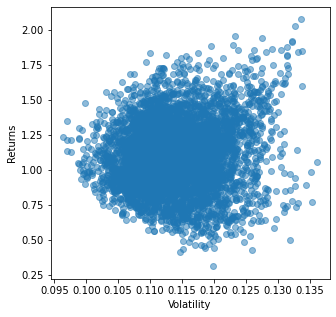

In [241]:
plt.figure(figsize = (5,5))
date = sorted(covariances.keys())[-1]
# plot efficient frontier
plt.scatter(x=portfolio_volatility[date],
            y=portfolio_returns[date],
            alpha=0.5)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

In [297]:
# empty dictionaries for sharpe ratios and best sharpe indexes by date
sharpe_ratio, max_sharpe_idxs, max_sharpe = {}, {}, {}
# loop through dates and get sharpe ratio for each portfolio
for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
        volatility = portfolio_volatility[date][i]
        sharpe_ratio.setdefault(date,[]).append(ret / volatility)
    # get the index of the best sharpe ratio for each date
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])
    max_sharpe[date] = np.max(sharpe_ratio[date])

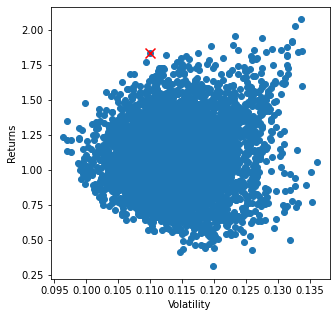

In [240]:
# latest date
plt.figure(figsize = (5,5))
date = sorted(covariances.keys())[-1]
cur_returns = portfolio_returns[date]
cur_volatility = portfolio_volatility[date]
plt.scatter(x=cur_volatility,
            y=cur_returns)
best_idx = max_sharpe_idxs[date]
plt.scatter(cur_volatility[best_idx],
            cur_returns[best_idx],
            marker='x',
            s = 100,
            color='red')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

In [312]:
date = sorted(covariances.keys())
perfomance = pd.DataFrame(index = date)
perfomance['Returns'] = None
perfomance['Volatility'] = None
perfomance['Sharpe_ratio'] = None
for j in range(len(D.columns)):
        perfomance[D.columns[j] + ' Weight'] = None
for i in range (len(date)):
    cur_returns = portfolio_returns[date[i]]
    cur_volatility = portfolio_volatility[date[i]]
    cur_weights = portfolio_weights[date[i]]
    best_idx = max_sharpe_idxs[date[i]]
    perfomance['Returns'][perfomance.index == date[i]] = cur_returns[best_idx]
    perfomance['Volatility'][perfomance.index == date[i]] = cur_volatility[best_idx]
    perfomance['Sharpe_ratio'][perfomance.index == date[i]] = max_sharpe[date[i]]
    for j in range(len(D.columns)):
        w = cur_weights[best_idx]
        perfomance[D.columns[j] + ' Weight'][perfomance.index == date[i]] = w[j]
perfomance

,Returns,Volatility,Sharpe_ratio,BNB Weight,ADA Weight,ETC Weight,VET Weight,LINK Weight
2019-04-01,0.169678,0.0341903,4.96275,0.445127,0.453974,0.0182811,0.0210473,0.0615707
2019-05-01,0.172641,0.0483256,3.57244,0.381867,0.0151003,0.539555,0.0508445,0.0126335
2019-06-03,0.600463,0.045788,13.114,0.371776,0.0263546,0.498247,0.003021,0.100602
2019-07-01,1.90392,0.0554689,34.324,0.210862,0.0714634,0.0366964,0.00320291,0.677776
2019-08-01,-0.192054,0.0367108,-5.23155,0.528774,0.0245005,0.437961,0.00171243,0.00705178
2019-09-02,0.0517508,0.0423245,1.22271,0.104423,0.0917601,0.783527,0.0149262,0.00536277
2019-10-01,-0.0948442,0.0449916,-2.10804,0.00337821,0.0434602,0.0944643,0.105435,0.753262
2019-11-01,0.44387,0.0373101,11.8968,0.201882,0.0538634,0.0488675,0.00973277,0.685654
2019-12-02,0.601935,0.0516808,11.6472,0.0489601,0.0533194,0.0357183,0.849407,0.0125956
2020-01-01,0.0666692,0.0696821,0.956763,0.0697062,0.0645984,0.71637,0.0548643,0.0944608
